In [1]:
# Do some imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt



# Load data and process data
data_dir = "./data/"

In [2]:
def load_data(data_dir):
    train = pd.read_json(data_dir+"train.json")
    test = pd.read_json(data_dir+"test.json")
    # Fill 'na' angles with zero
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.inc_angle = test.inc_angle.astype(float).fillna(0.0)
    return train, test

train, test = load_data(data_dir)

In [3]:
# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1"]])
    X_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis]
                            , X_band2[:, :, :, np.newaxis]
                            ,((X_band1+X_band2)/2)[:, :, :, np.newaxis]], axis=-1)
    return imgs

X_train = process_images(train)
X_test = process_images(test)

X_angle_train = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train = np.array(train["is_iceberg"])

In [4]:
X_train.shape

(1604, 75, 75, 3)

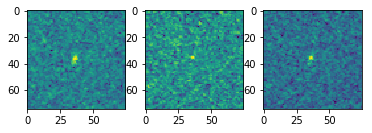

1


In [5]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(X_train[2,:,:,0])
ax[1].imshow(X_train[2,:,:,1])
ax[2].imshow(X_train[2,:,:,2])
plt.show()
print(y_train[2])

The MatLab code for doing the EMD can be run from python by starting a MatLab-engine instance

In [6]:
import matlab.engine

In [7]:
#epsilon = 0.1
#conn = '8m'
numberimfs = 4
eng = matlab.engine.start_matlab()

In [51]:
# Calculate IMFs, residue, and medel(?) using matlab wrapper
def IEMD(img, epsilon=0.1, numberimfs=4, conn='8m'):
    print(epsilon)
    matlab_arr = matlab.double(img.tolist())
    matlab_imfs, matlab_residue, matlab_medel = eng.IEMD_public(matlab_arr, epsilon, numberimfs, conn, nargout=3) 
    
    imfs = np.asarray(matlab_imfs)
    residue = np.asarray(matlab_residue)
    medel = np.asarray(matlab_medel)
    return imfs, residue, medel

In [47]:
def plot_IEMD(imfs, residues):
    plt.figure(2, figsize=(12, 20))
    plt.clf()
    plt.tight_layout(h_pad=3)
    plt.subplots_adjust(hspace=0.1)

    for i in range(np.shape(imfs)[2]):
        plt.subplot(np.shape(imfs)[2],2,1+2*i)
        plt.imshow(imfs[:,:,i],cmap='plasma')
        plt.title("IMF " + str(i + 1))
        plt.colorbar()
        plt.subplot(np.shape(imfs)[2],2,2*i+2)
        plt.imshow(residues[:,:,i],cmap='plasma')
        plt.title("Residue " + str(i + 1))
        plt.colorbar()
    plt.show()

In [48]:
def print_label(idx):
    if y_train[idx]:
        print("Iceberg")
    else:
        print("Ship")

In [59]:
def normalize(img):
    img = img-img.min()
    img = img/(img.max())
    return img

Ship


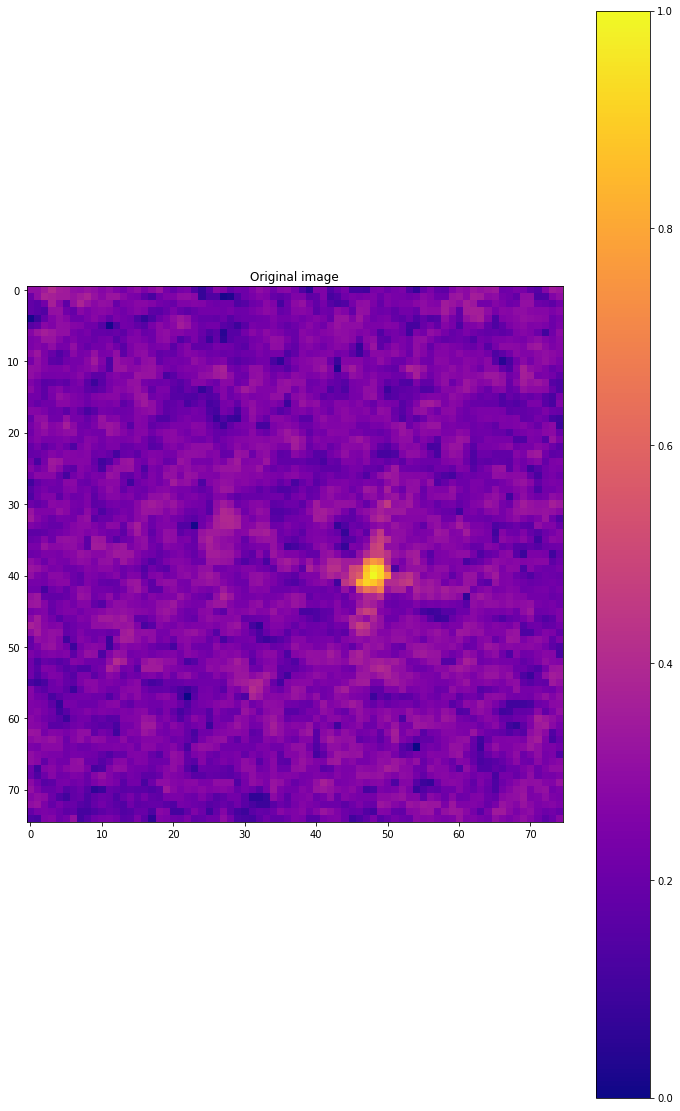

0.01


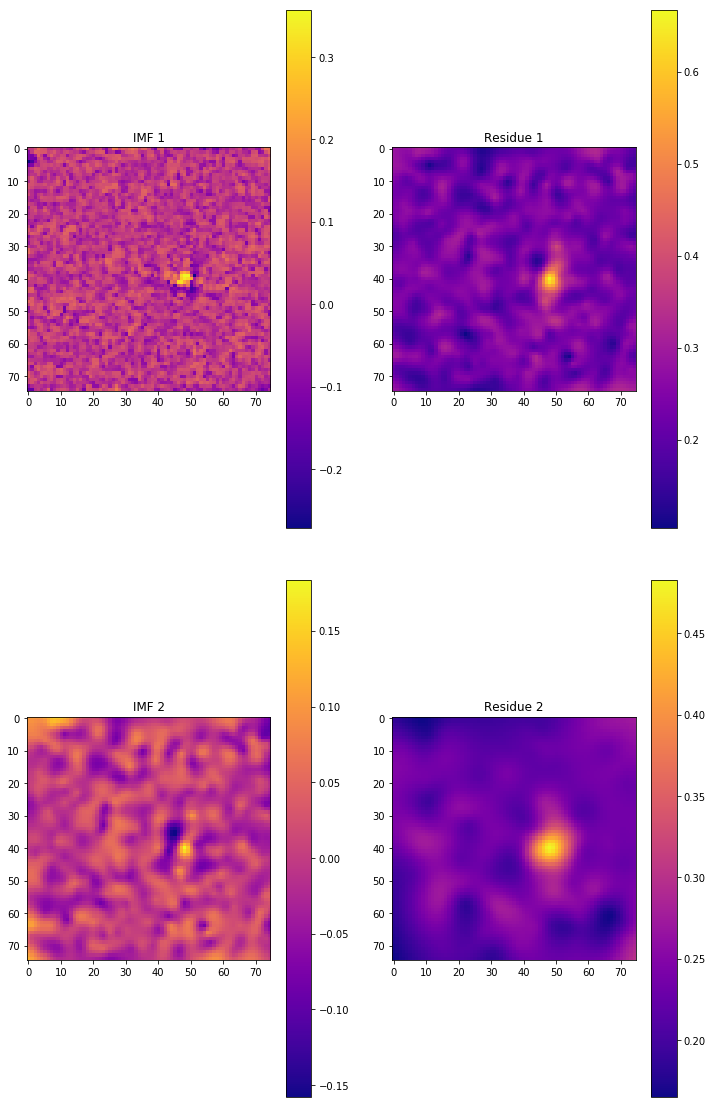

In [67]:
idx =11
print_label(idx)

img_band1 = X_train[idx,:,:,0]
img_band1 = normalize(img_band1)

plt.imshow(img_band1,cmap='plasma')
plt.title('Original image')
plt.colorbar()
plt.show()

imfs1, residues1, medel1 = IEMD(img_band1,0.01,2,'4')
plot_IEMD(imfs1, residues1)



In [66]:
imfs1.shape


(75, 75)

In [13]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools


data1 = [
    go.Surface(
        z=img_band1
    )
]

layout1 = go.Layout(
    title='Original image',
    autosize=False,
    width=500,
    height=500,
)



fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig, filename='orig')




In [39]:
data1 = [
    go.Surface(
        z=imfs1[:,:,0]
    )
]

layout1 = go.Layout(
    title='First imf',
    autosize=False,
    width=500,
    height=500,
)



fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig, filename='imf1')


In [136]:
data1 = [
    go.Surface(
        z=imfs1[:,:,1]
    )
]

layout1 = go.Layout(
    title='Second imf',
    autosize=False,
    width=500,
    height=500,
)



fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig, filename='imf2')


In [40]:
data1 = [
    go.Surface(
        z=residue1[:,:,0]
    )
]

layout1 = go.Layout(
    title='First residue',
    autosize=False,
    width=500,
    height=500,
)



fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig, filename='res1')


In [41]:
data1 = [
    go.Surface(
        z=residue1[:,:,1]
    )
]

layout1 = go.Layout(
    title='Second residue',
    autosize=False,
    width=500,
    height=500,
)



fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig, filename='res2')


===============================================================================================

Next we build the dataset now with the IMFs included each as their own column.

In [12]:
train = pd.read_json(data_dir+"train.json")

In [13]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [14]:
# Create the columns in the pandas object for each IMF
for band in range(1,3):
    for imf in range(1,numberimfs + 1):
        column_name = "band_" + str(band) + "_imf_" + str(imf)
        #train[column_name] = np.nan
        train[column_name] = np.empty((len(train), 0)).tolist()
        #train[column_name] = np.zeros((75,75)).reshape(1, 75 * 75).tolist()
train.head()

,band_1,band_2,id,inc_angle,is_iceberg,band_1_imf_1,band_1_imf_2,band_1_imf_3,band_1_imf_4,band_2_imf_1,band_2_imf_2,band_2_imf_3,band_2_imf_4
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,[],[],[],[],[],[],[],[]
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,[],[],[],[],[],[],[],[]
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,[],[],[],[],[],[],[],[]
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,[],[],[],[],[],[],[],[]
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,[],[],[],[],[],[],[],[]


In [15]:
# Calculate every IMF for every image
from timeit import default_timer as timer
num_img = len(X_train)
start_time = timer()
for i, images in enumerate(X_train):
    band1_imf, _, _ = IEMD(images[:,:,0])
    band2_imf, _, _ = IEMD(images[:,:,1])
    
    for imf in range(numberimfs):
        column_name_band1 = "band_1_imf_" + str(imf + 1)
        column_name_band2 = "band_2_imf_" + str(imf + 1)
        train.set_value(i, column_name_band1, band1_imf[:,:,imf].reshape(75 * 75).tolist())
        train.set_value(i, column_name_band2, band2_imf[:,:,imf].reshape(75 * 75).tolist())
    
    msg = "Image " + str(i) + "/" + str(num_img) + " completed..."
    print (msg, end="\r")
    if i == 10:
        break
print("Total run time: " + str(timer() - start_time))

Total run time: 31.466616042998794


================================================================================================================

Then we validate that it's correct

In [16]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg,band_1_imf_1,band_1_imf_2,band_1_imf_3,band_1_imf_4,band_2_imf_1,band_2_imf_2,band_2_imf_3,band_2_imf_4
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,"[-1.0988919318538137, 1.2394438759956756, 1.40...","[1.1319092476878723, -0.3276233547447873, -1.8...","[-0.794302317901618, -0.8981179435983222, -1.0...","[-0.11552031905409788, -0.144208450196448, -0....","[4.605481934633644, 1.8531034167335747, -0.445...","[-1.391348204680753, -0.6644049759709105, 0.49...","[-1.1130209481088222, -1.4270182308546921, -1....","[1.2058021647787474, 1.171156506013092, 1.1340..."
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,"[2.427835734653854, -1.378095010622019, -2.338...","[-2.825449222801808, -1.581870904849012, -0.49...","[0.777312735470312, 0.6550471867318157, 0.5287...","[-0.7911746285929953, -0.7220820441079043, -0....","[-2.6411338709499432, -0.6127070688917229, -0....","[-1.7494047701179056, -0.5878815035860896, 0.4...","[-0.7410424110050293, -0.5397889650911498, -0....","[-1.014016176286356, -0.8394511398386912, -0.6..."
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,"[-2.3517035974427927, -2.510544989952905, -2.9...","[-0.07528019462830571, 0.044060073841933445, 0...","[0.01941453307530594, 0.03363684017909563, 0.0...","[-0.10098725977174894, -0.04115599631823841, 0...","[-2.9455213595240366, -1.7547973946705042, 1.9...","[1.8597998744434676, 1.580819665981437, 1.4414...","[1.0314600417035429, 0.907646675490458, 0.7921...","[0.3392259250831917, 0.3342704539634953, 0.328..."
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,"[0.37455575552303344, -0.022349550135686513, -...","[0.6327495403672572, 0.5769199350554572, 0.688...","[0.5233987448300823, 0.3934941993193206, 0.232...","[-0.4771500609343824, -0.41832076020040976, -0...","[0.29306963239014294, 0.9433731331296258, 1.45...","[0.24612225133319043, -0.1824086219775154, -0....","[0.7694352307072734, 0.9417714355541058, 1.076...","[-0.154049417685319, -0.17252684608729252, -0...."
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,"[-1.8041258832254243, 1.1693541807144356, 1.06...","[-0.9845684787081268, -0.6014125404179822, 0.1...","[1.8111922428873548, 1.3180412665660342, 0.721...","[0.28868938036303327, 0.2583014430011703, 0.21...","[-2.4759657869869898, -4.873336574781206, -4.3...","[0.553135430171551, -0.0596395318044074, -0.52...","[1.576018749911782, 1.5508947952609518, 1.4858...","[-0.416428143059961, -0.43503541833776893, -0...."


In [15]:
#Verify that IMFs fit with the correct image
def plot_IEMD_from_row(row, band):
    img = np.reshape(row["band_" + str(band)], (75,75))
    
    fig, ax = plt.subplots(2,1 + np.shape(imfs)[2], figsize=(20, 12))
    fig.tight_layout(h_pad=3)
    fig.subplots_adjust(hspace=0.1)

    ax[0][0].imshow(img)
    ax[0][0].set_title("Original image")
    ax[1][0].imshow(img)
    ax[1][0].set_title("Original image")
    
    filtered_img_sub = np.copy(img)
    for imf_idx in range(numberimfs):
        column_name = "band_" + str(band) + "_imf_" + str(imf_idx + 1)
        imf = np.reshape(row[column_name], (75,75))
        
        ax[0][imf_idx + 1].imshow(imf)
        ax[0][imf_idx + 1].set_title("IMF" + str(imf_idx + 1))
        
        filtered_img_sub = filtered_img_sub - imf
        ax[1][imf_idx + 1].imshow(filtered_img_sub)
        ax[1][imf_idx + 1].set_title(str(imf_idx + 1) + " IMF(s) subtracted")


    plt.show()

In [16]:
plot_IEMD_from_row(train.iloc[5], 1)

ValueError: cannot reshape array of size 0 into shape (75,75)

In [ ]:
plot_IEMD_from_row(train.iloc[5], 2)

In [ ]:
train.head(20).to_json("test.JSON")

In [ ]:
train_temp = pd.read_json("test.JSON")

In [ ]:
train_temp.head(20).sort_index()

================================================================================================================

Works, kinda, so then we calculate all the indices

In [ ]:
# Calculate every IMF for every image
from timeit import default_timer as timer
def IMF_to_JSON(data):
    num_img = len(data)
    start_time = timer()
    for i, images in enumerate(data):
        band1_imf, _, _ = IEMD(images[:,:,0])
        band2_imf, _, _ = IEMD(images[:,:,1])

        for imf in range(numberimfs):
            column_name_band1 = "band_1_imf_" + str(imf + 1)
            column_name_band2 = "band_2_imf_" + str(imf + 1)
            train.set_value(i, column_name_band1, band1_imf[:,:,imf].reshape(75 * 75).tolist())
            train.set_value(i, column_name_band2, band2_imf[:,:,imf].reshape(75 * 75).tolist())

        msg = "Image " + str(i) + "/" + str(num_img) + " completed..."
        print (msg, end="\r")
    print("Total run time: " + str(timer() - start_time))
    print("Saving to JSON...")
    train.to_json("../data/train_with_imfs.json")
    print("Done!")

In [ ]:
IMF_to_JSON(X_train)

In [17]:
import bisect
from numba import jit

@jit

def imadjust(src, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    assert len(src.shape) == 2 ,'Input image should be 2-dims'

    tol = max(0, min(100, tol))

    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.histogram(src,bins=list(range(256)),range=(0,255))[0]

        # Cumulative histogram
        cum = hist.copy()
        for i in range(0, 255): cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    vs = src-vin[0]
    vs[src<vin[0]]=0
    vd = vs*scale+0.5 + vout[0]
    vd[vd>vout[1]] = vout[1]
    dst = vd

    return dst

In [28]:
from sklearn.preprocessing import normalize

img = np.copy(X_train[5,:,:,0])
norm_img = np.copy(img)
min_val = np.min(norm_img)
norm_img = norm_img - min_val
max_val = np.max(norm_img)
norm_img = (norm_img / max_val) * 255

In [29]:
adj_img = imadjust(norm_img)

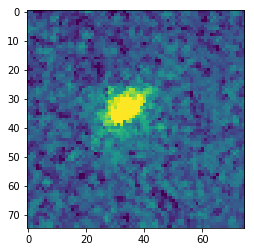

In [30]:
plt.imshow(adj_img)
plt.show()

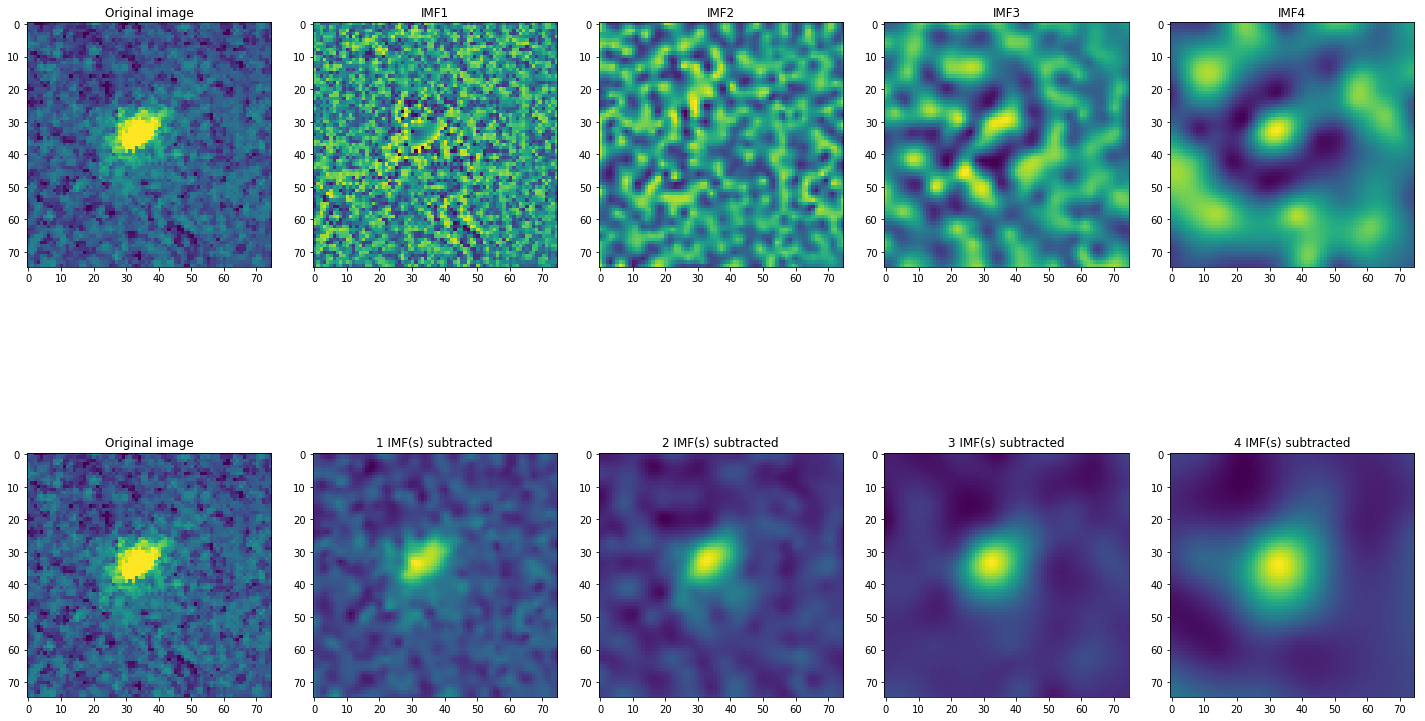

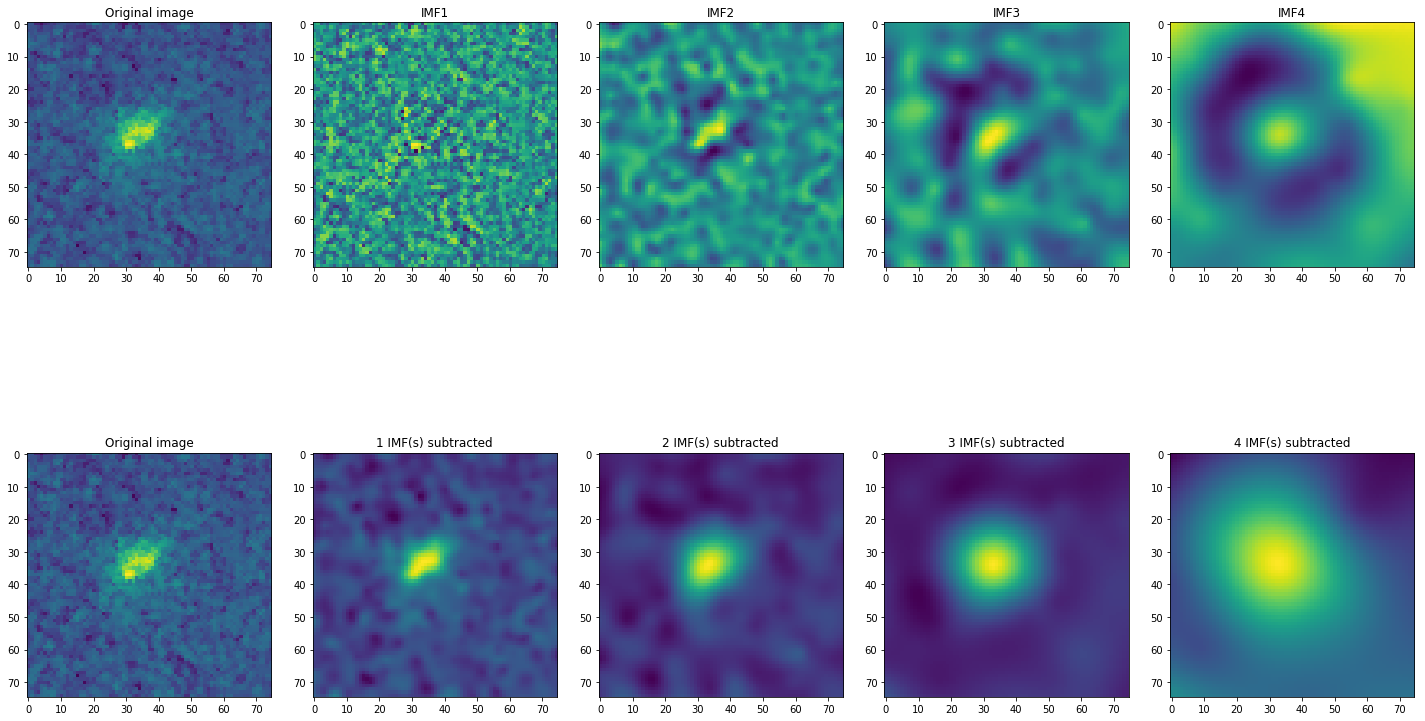

Iceberg


In [31]:
idx =5

imfs, residue, medel = IEMD(adj_img)
plot_IEMD(adj_img, imfs)

imfs, residue, medel = IEMD(img)
plot_IEMD(img, imfs)

print_label(idx)